## Intelligent operation：table recognition

#### Background introduction
    
Table recognition has a wide range of applications in the financial industry such as insurance claims, financial report analysis,  and information entry. At present, form recognition in the financial industry is mainly based on manual entry, and the development of an automatic form recognition has become a problem to be solved.

In the financial industry, table images mainly include cell-intensive tables of the checklist, large cell tables of application forms,  photographed tables, and tilted tables.
     
   
![](https://ai-studio-static-online.cdn.bcebos.com/195a137613fc4fa5acc15a7bb7fd23f6461d90f355284bffb550615dd50b0394)
![](https://ai-studio-static-online.cdn.bcebos.com/4e2aceb15b484509b200d3fc5b229d175c0b9dd8f29945e9a2be799510af77b3)
![](https://ai-studio-static-online.cdn.bcebos.com/d47b88169cee4ee6ab2d8af1fe8a24cb0923bcabd48e40fdb7e6aa7b3fac53b9) 
 
     
     
Current table recognition algorithms cannot handle table images in these scenarios well. In this example, we use the newly released table recognition model SLANet of PP-Structurev2 to demonstrate how to recognize tables.



## 2. Set up

In [1]:
# Git clone the project
! git clone -b dygraph https://gitee.com/paddlepaddle/PaddleOCR

Cloning into 'PaddleOCR'...
remote: Enumerating objects: 45032, done.
remote: Counting objects: 100% (19411/19411), done.
remote: Compressing objects: 100% (6942/6942), done.
remote: Total 45032 (delta 14187), reused 17346 (delta 12332), pack-reused 25621
Receiving objects: 100% (45032/45032), 335.31 MiB | 5.42 MiB/s, done.
Resolving deltas: 100% (32048/32048), done.
Checking out files: 100% (1617/1617), done.


In [ ]:
# Setup environment

!pip install protobuf==3.19
!pip install -r /content/PaddleOCR/requirements.txt

In [6]:
pip install paddlepaddle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 121.6 MB 43 kB/s 
     |████████████████████████████████| 385 kB 54.9 MB/s 


### 2.2 Data preparation

We synthesized the table data using this[Table Generation Tool](https://github.com/WenmuZhou/TableGeneration).

Unzip the data 

In [ ]:
! cd data/data165849 && tar -xf table_gen_dataset.tar && cd -
! wc -l data/data165849/table_gen_dataset/gt.txt

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.lastuseddate#PS'
/home/aistudio
20000 data/data165849/table_gen_dataset/gt.txt


#### 2.2.1 Split the data into train and validation sets
Training dataset is 90% of the overall data, validation is 10%.

In [ ]:
import random
with open('/home/aistudio/data/data165849/table_gen_dataset/gt.txt') as f:
    lines = f.readlines()
random.shuffle(lines)
train_len = int(len(lines)*0.9)
train_list = lines[:train_len]
val_list = lines[train_len:]

# Save the result
with open('/home/aistudio/train.txt','w',encoding='utf-8') as f:
    f.writelines(train_list)
with open('/home/aistudio/val.txt','w',encoding='utf-8') as f:
    f.writelines(val_list)

After splitting, the data size is below

|Type|Size|Iamge path|Label path|
|---|---|---|---|
|Training|18000|/home/aistudio/data/data165849/table_gen_dataset|/home/aistudio/train.txt|
|Validation|2000|/home/aistudio/data/data165849/table_gen_dataset|/home/aistudio/val.txt|



#### 2.2.2 EDA on the annotated dataset


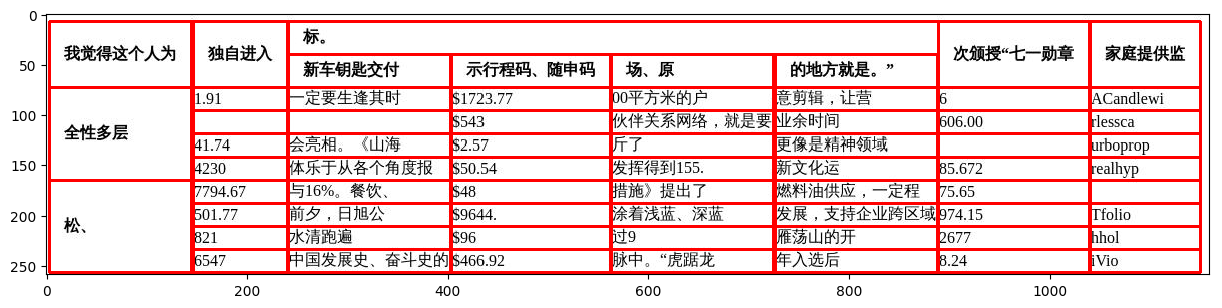

In [ ]:
import cv2
import os, json
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def parse_line(data_dir, line):
    data_line = line.strip("\n")
    info = json.loads(data_line)
    file_name = info['filename']
    cells = info['html']['cells'].copy()
    structure = info['html']['structure']['tokens'].copy()

    img_path = os.path.join(data_dir, file_name)
    if not os.path.exists(img_path):
        print(img_path)
        return None
    data = {
        'img_path': img_path,
        'cells': cells,
        'structure': structure,
        'file_name': file_name
    }
    return data

def draw_bbox(img_path, points, color=(255, 0, 0), thickness=2):
    if isinstance(img_path, str):
        img_path = cv2.imread(img_path)
    img_path = img_path.copy()
    for point in points:
        cv2.polylines(img_path, [point.astype(int)], True, color, thickness)
    return img_path


def rebuild_html(data):
    html_code = data['structure']
    cells = data['cells']
    to_insert = [i for i, tag in enumerate(html_code) if tag in ('<td>', '>')]

    for i, cell in zip(to_insert[::-1], cells[::-1]):
        if cell['tokens']:
            text = ''.join(cell['tokens'])
            # skip empty text
            sp_char_list = ['<b>', '</b>', '\u2028', ' ', '<i>', '</i>']
            text_remove_style = skip_char(text, sp_char_list)
            if len(text_remove_style) == 0:
                continue
            html_code.insert(i + 1, text)

    html_code = ''.join(html_code)
    return html_code


def skip_char(text, sp_char_list):
    """
    skip empty cell
    @param text: text in cell
    @param sp_char_list: style char and special code
    @return:
    """
    for sp_char in sp_char_list:
        text = text.replace(sp_char, '')
    return text

save_dir = '/home/aistudio/vis'
os.makedirs(save_dir, exist_ok=True)
image_dir = '/home/aistudio/data/data165849/'
html_str = '<table border="1">'

# Decode the cell annotation and display the HTML table.
data = parse_line(image_dir, val_list[40])

img = cv2.imread(data['img_path'])
img_name = ''.join(os.path.basename(data['file_name']).split('.')[:-1])
img_save_name = os.path.join(save_dir, img_name)
boxes = [np.array(x['bbox']) for x in data['cells']]
show_img = draw_bbox(data['img_path'], boxes)
cv2.imwrite(img_save_name + '_show.jpg', show_img)

html = rebuild_html(data)
html_str += html
html_str += '</table>'

# Display the HTML string
from IPython.core.display import display, HTML
display(HTML(html_str))
# Display the cell coordinates
plt.figure(figsize=(15,15))
plt.imshow(show_img)
plt.show()


### 2.3 Model training

We make use of the table recognition model [SLANet](https://github.com/PaddlePaddle/PaddleOCR/blob/dygraph/configs/table/SLANet.yml) from PP-Structurev2.

SLANet is PP-Structurev2's new model, compared to TableRec-RARE from PP-Structurev1. Its performance is better and faster.

|Algorithm|Acc|[TEDS(Tree-Edit-Distance-based Similarity)](https://github.com/ibm-aur-nlp/PubTabNet/tree/master/src)|Speed|
| --- | --- | --- | ---|
| TableRec-RARE(ours) | 71.73%| 93.88% |779ms|
| SLANet(ours) | 76.31%|    95.89%|766ms|

Before training, we first download the pre-trained model


In [ ]:
os.chdir('/home/aistudio/PaddleOCR')
# Download the English pre-trained model
! wget  -nc -P  ./pretrain_models/  https://paddleocr.bj.bcebos.com/ppstructure/models/slanet/en_ppstructure_mobile_v2.0_SLANet_train.tar --no-check-certificate
! cd ./pretrain_models/ && tar xf en_ppstructure_mobile_v2.0_SLANet_train.tar  && cd ../

Use the command below to start training the model. Belows are the parameters that we can adjust based on our data

|Parameters|Values|Meaning|
|---|---|---|
|Global.pretrained_model|./pretrain_models/en_ppstructure_mobile_v2.0_SLANet_train/best_accuracy.pdparams|Path to the pre-trained model|
|Global.eval_batch_step|562|How many steps will the model be evaluated, generally set it to be the total steps per epoch|
|Optimizer.lr.name|Const|Learning rate decay |
|Optimizer.lr.learning_rate|0.0005|Learning rate |
|Train.dataset.data_dir|/home/aistudio/data/data165849|Path to the training images |
|Train.dataset.label_file_list|/home/aistudio/data/data165849/table_gen_dataset/train.txt|Path to the label of training images |
|Train.loader.batch_size_per_card|32|Batch_size per card |
|Train.loader.num_workers|1|Number of workers |
|Eval.dataset.data_dir|/home/aistudio/data/data165849|Path to the validation data |
|Eval.dataset.label_file_list|/home/aistudio/data/data165849/table_gen_dataset/val.txt|Path to labels of validation data |
|Eval.loader.batch_size_per_card|32|Batch_size |
|Eval.loader.num_workers|1|Number of workers |


Path to save the config file `/home/aistudio/SLANet_ch.yml`


In [ ]:
import os
os.chdir('/home/aistudio/PaddleOCR-release-2.6')
! python3 tools/train.py -c /home/aistudio/SLANet_ch.yml

After 7 epoches, the accuracy reaches 97%

### 2.4 Validation

After training, use the commands below to test the best model on validation data

### 2.5 Predict using inference model

In [17]:
!python3 /content/PaddleOCR/ppstructure/table/predict_structure.py \
    --table_model_dir=/content/PaddleOCR/SLANet_ch/infer \
    --table_char_dict_path=/content/PaddleOCR/ppocr/utils/dict/table_structure_dict.txt \
    --image_dir=/content/PaddleOCR/doc/imgs/validation.PNG \
    --output=/content/PaddleOCR/output/inference

E1209 07:26:03.101912   514 analysis_config.cc:96] Please compile with gpu to EnableGpu()
[2022/12/09 07:26:04] ppocr INFO: result: ['<html>', '<body>', '<table>', '<tr>', '<td', ' rowspan="2"', '>', '</td>', '<td', ' rowspan="2"', '>', '</td>', '<td', ' colspan="4"', '>', '</td>', '<td', ' rowspan="2"', '>', '</td>', '<td', ' rowspan="2"', '>', '</td>', '</tr>', '<tr>', '<td></td>', '<td></td>', '<td></td>', '<td></td>', '</tr>', '<tr>', '<td', ' rowspan="4"', '>', '</td>', '<td></td>', '<td></td>', '<td></td>', '<td></td>', '<td></td>', '<td></td>', '<td></td>', '</tr>', '<tr>', '<td></td>', '<td></td>', '<td></td>', '<td></td>', '<td></td>', '<td></td>', '<td></td>', '</tr>', '<tr>', '<td></td>', '<td></td>', '<td></td>', '<td></td>', '<td></td>', '<td></td>', '<td></td>', '</tr>', '<tr>', '<td></td>', '<td></td>', '<td></td>', '<td></td>', '<td></td>', '<td></td>', '<td></td>', '</tr>', '<tr>', '<td', ' rowspan="4"', '>', '</td>', '<td></td>', '<td></td>', '<td></td>', '<td></td>',

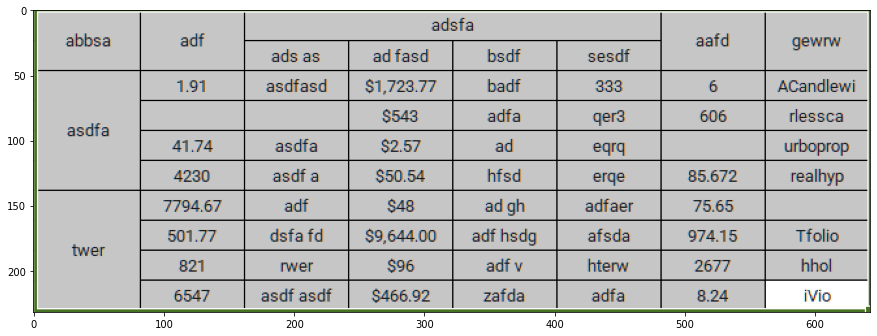

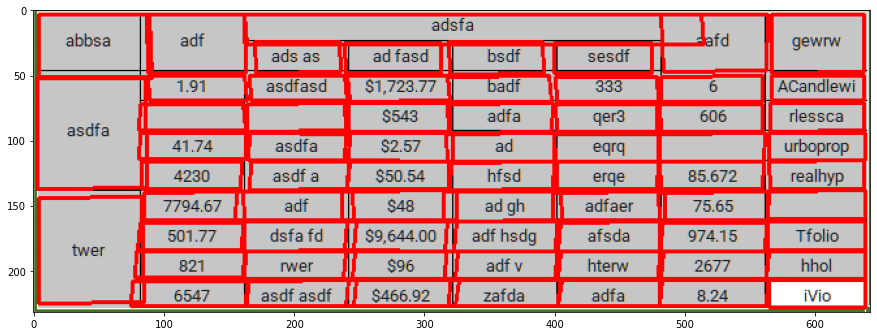

In [20]:
# Display original image
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

show_img = cv2.imread('/content/PaddleOCR/doc/imgs/validation.PNG')
plt.figure(figsize=(15,15))
plt.imshow(show_img)
plt.show()

# Display the predicted cells
show_img = cv2.imread('/content/PaddleOCR/output/inference/validation.PNG')
plt.figure(figsize=(15,15))
plt.imshow(show_img)
plt.show()

### 2.6 Table recognition

After table structure recognition, we can use OCR model to detect and recognize the text in the table.

First, we download the PP-OCRv3 text detection and recognition model

In [ ]:
! wget  -nc -P  ./inference/ https://paddleocr.bj.bcebos.com/PP-OCRv3/chinese/ch_PP-OCRv3_det_slim_infer.tar --no-check-certificate
! wget  -nc -P  ./inference/ https://paddleocr.bj.bcebos.com/PP-OCRv3/chinese/ch_PP-OCRv3_rec_slim_infer.tar --no-check-certificate
! cd ./inference/ && tar xf ch_PP-OCRv3_det_slim_infer.tar && tar xf ch_PP-OCRv3_rec_slim_infer.tar  && cd ../

In [29]:
## Command to extract the table contents
import os;os.chdir('/content/PaddleOCR/ppstructure')
! python3 table/predict_table.py \
    --det_model_dir=/content/inference/ch_PP-OCRv3_det_slim_infer \
    --rec_model_dir=/content/inference/ch_PP-OCRv3_rec_slim_infer  \
    --table_model_dir=/content/PaddleOCR/SLANet_ch/infer \
    --rec_char_dict_path=../ppocr/utils/ppocr_keys_v1.txt \
    --table_char_dict_path=../ppocr/utils/dict/table_structure_dict.txt \
    --image_dir=/content/PaddleOCR/doc/imgs/validation.PNG \
    --output=../output/table

E1209 07:37:19.972203   751 analysis_config.cc:96] Please compile with gpu to EnableGpu()
E1209 07:37:20.592476   751 analysis_config.cc:96] Please compile with gpu to EnableGpu()
E1209 07:37:21.083103   751 analysis_config.cc:96] Please compile with gpu to EnableGpu()
E1209 07:37:21.647564   751 analysis_config.cc:96] Please compile with gpu to EnableGpu()
[2022/12/09 07:37:22] ppocr INFO: [0/1] /content/PaddleOCR/doc/imgs/validation.PNG
[2022/12/09 07:37:23] ppocr DEBUG: dt_boxes num : 63, elapse : 0.32153820991516113
[2022/12/09 07:37:28] ppocr DEBUG: rec_res num  : 63, elapse : 4.894193649291992
[2022/12/09 07:37:28] ppocr INFO: <html><body><table><tr><td rowspan="2"> abbsa</td><td rowspan="2"> adf </td><td colspan="4"> adsfa</td><td rowspan="2"> aafd</td><td rowspan="2"> gewrw</td></tr><tr><td> ads as</td><td> ad fasd</td><td> bsdf </td><td>sesdf</td></tr><tr><td rowspan="4"> asdfa </td><td>1.91</td><td> asdfasd</td><td>$1,723.77</td><td> badf </td><td>333</td><td>6</td><td> ACand

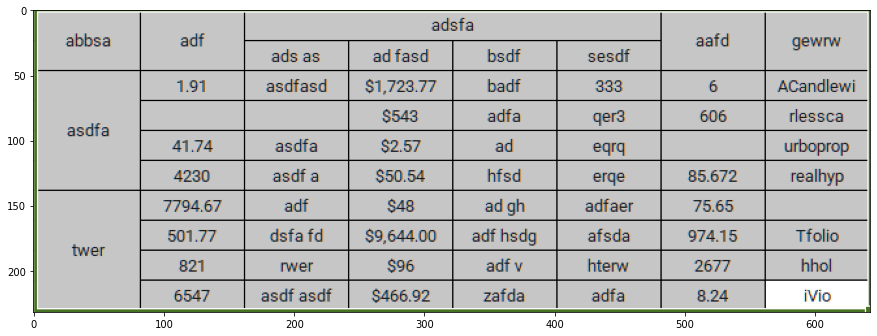

In [36]:
# Display the result
show_img = cv2.imread('/content/PaddleOCR/doc/imgs/validation.PNG')
plt.figure(figsize=(15,15))
plt.imshow(show_img)
plt.show()

from IPython.core.display import display, HTML
display(HTML('<html><body><table><tr><td rowspan="2"> abbsa</td><td rowspan="2"> adf </td><td colspan="4"> adsfa</td><td rowspan="2"> aafd</td><td rowspan="2"> gewrw</td></tr><tr><td> ads as</td><td> ad fasd</td><td> bsdf </td><td>sesdf</td></tr><tr><td rowspan="4"> asdfa </td><td>1.91</td><td> asdfasd</td><td>$1,723.77</td><td> badf </td><td>333</td><td>6</td><td> ACandlewi </td></tr><tr><td></td><td></td><td>$543</td><td>adfa</td><td>qer3 </td><td>606</td><td>rlessca</td></tr><tr><td>41.74</td><td> asdfa</td><td>$2.57</td><td>ad</td><td>eqrq</td><td></td><td>urboprop</td></tr><tr><td>4230 </td><td> asdf a</td><td>$50.54</td><td> hfsd</td><td> erqe</td><td>85.672</td><td>realhyp</td></tr><tr><td rowspan="4"> twer</td><td>7794.67</td><td>adf </td><td> $48</td><td>ad gh</td><td> adfaer</td><td>75.65</td><td></td></tr><tr><td>501.77</td><td>dsfa fd</td><td>$9,644.00</td><td>adf hsdg</td><td> afsda</td><td>974.15</td><td>Tfolio</td></tr><tr><td>821</td><td>rwer</td><td>$96</td><td>adf v</td><td>hterw</td><td>2677</td><td> hhol </td></tr><tr><td>6547</td><td> asdf asdf </td><td>$466.92</td><td>zafda</td><td>adfa</td><td>8.24</td><td>ivio</td></tr></table></body></html>'))

# Final remarks

Through this project, we can see that forms/tables document can be recognized and extracted using deep learning OCR techniques. This technique will save up a lot of human data entry time.